# Sign spotting analysis
In this notebook, we analyze the differences between the two models that we created: the one that was trained using engineered features meant to represent phonology (the *linguistic model*), and the other that was trained using Mediapipe landmarks (the *landmark model*). We study the two models in two different ways:

1. We observe which true positive (TP) spottings of each target sign are made by the linguistic model and the landmark model. The TP spottings that are made by one model and not the other are explicitly printed so we can manually analyze these instances.
2. We investigate which false positive (FP) spottings occur for a set of confusable signs. These confusable signs are determined for each target, and we find those signs to be confusable signs for a given target if they only differ in one linguistic property (the *distance property*) from that target sign, e.g. the handedness. We determine which distance properties are especially confusable for each model by seeing how often the confusable signs are spotted and keeping track of their distance properties.

In [1]:
# imports
import os

from tensorflow import keras
from keras.optimizers import Adam

import importlib

# Keep python tools up to date
from tools import tools, create_model, constants, sign_spot_tools
importlib.reload(tools)
importlib.reload(create_model)
importlib.reload(constants)
importlib.reload(sign_spot_tools)

# Import all functions from the tools
from tools.tools import load_dict, store_dict, ms_to_frame
from tools.create_model import SupCon_loss, create_encoder
from tools.constants import PATHS # Path constants
from tools.sign_spot_tools import*

import numpy as np
from scipy.spatial.distance import cdist
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from statsmodels.stats.contingency_tables import mcnemar

# Set a numpy seed for consistent results
np.random.seed(123)

In [2]:
# Performs mcnemar's test and prints the results
# We also test the significance here
def mcnemar_test(data, alpha = 0.05):
    res = mcnemar(data, exact=False)
    chi_stat, p_val = res.statistic, res.pvalue
    significant = p_val < alpha
    symbol = '<' if significant else '>='
    print('Chi-square statistic:', chi_stat)
    print('p-value: {} (p {} {})'.format(round(p_val, 5), symbol, alpha))
    return chi_stat, p_val, significant

In [3]:
# Load the model checkpoints, make sure you trained both model types for this!
# Otherwise a warning will be printed and you cannot run the rest of the code.
paths = ['model_linguistic', 'model_lmrks', 'embedding_linguistic', 'embedding_lmrks', 'anns_test']
all_paths_known = True
temperature = 0.07
num_classes = 2711
# loss = SupCon_loss()
for path in paths:
    if not os.path.exists(PATHS[path]):
        all_paths_known = False
        break

if all_paths_known:
    print('Loading required data...')
    # Loading the models (one trained w/ linguistic features, one with landmark features)
    model_linguistic = keras.models.load_model(PATHS['model_linguistic'], custom_objects={'SupCon_loss':SupCon_loss},
                                               compile=False) 
    model_lmrks = keras.models.load_model(PATHS['model_lmrks'], custom_objects={'SupCon_loss':SupCon_loss},compile=False)
    
    model_linguistic.compile(optimizer = 'Adam', loss=SupCon_loss(temperature, num_classes))
    model_lmrks.compile(optimizer = 'Adam', loss=SupCon_loss(temperature, num_classes))
    
    # Also load the embedding dictionaries, which have a reference embedding for each sign based on train data
    embedding_linguistic = load_dict(PATHS['embedding_linguistic'])
    embedding_lmrks = load_dict(PATHS['embedding_lmrks'])

    # Load the test set annotations
    anns = load_dict(PATHS['anns_test'])
    print('Successfully loaded checkpoints and reference embeddings.')
else:
    print('***WARNING: you should run sign_spotting_training for both the landmark and linguistic features.***')
    print('***The code below will NOT run without both checkpoints and their corresponding reference embds.***')

Loading required data...
Successfully loaded checkpoints and reference embeddings.


In [4]:
# Create the embeddings of the test set videos with a sliding window
# We do this separately for each model because they both create different kinds of embeddings
print('Embedding test set videos with landmark model...')
_, vid_embd_lmrks = make_test_video_embds(model_lmrks, only_lmrks = True)
print('Embedding test set videos with linguistic model...')
_, vid_embd_linguistic = make_test_video_embds(model_linguistic, only_lmrks = False)

Embedding test set videos with landmark model...
Loading annotations and getting test video ids...
Loading test video features...
Done.                                                                                                    
Embedding test set videos with linguistic model...
Loading annotations and getting test video ids...
Loading test video features...
Done.                                                                                                    


In [5]:
# Analyze the TP and FN spottings for our model
def get_tp_and_fn_spottings(anns, video_embd_dict, reference_sign_embds, labels, tolerance=25, spotting_thresh=0.5):
    tp, fn = 0, 0
    tp_instances = {} # FP, TN, FN, TN instances with info such as which sign we mistook for the target sign
    total_positives = 0
    
    for i, video in enumerate(anns): # Loop over the video_ids
        print('video {}/{}'.format(i+1, len(list(anns.keys()))), end = '\r')
        video_embd = video_embd_dict[video]
        ann = anns[video]
        tp_instances[video] = {}
        
        # Loop over the signs and their embeddings
        for sign, reference_embd in reference_sign_embds.items():
            # The sign variable above is numerical, so convert to string 
            str_label = find_target_label(sign, labels)[0]
            if len(str_label) == 0: # If sign is not in train labels, we skip it
                continue
            timestamps = [] # Start with an empty list of timestamps of annotations
            # Get all annotation timestamps of the sign - if they exist
            if str_label in ann: 
                timestamps = sorted(list(set(ann[str_label])))
            # Skip signs for which we have no target annotations at all, or no distractors
            if len(timestamps) == 0:
                continue
            total_positives += len(timestamps)
            # Get tolerance windows for target annotations 
            target_windows = [(t[0]-tolerance, t[0]) for t in timestamps]
            
            # Compute the distance for each result of using the sliding window
            dist = cdist(video_embd, reference_embd.reshape(1,-1), metric = 'cosine').flatten()
            
            # Get the frames below a threshold cosine distance and make them into timespans
            below_thresh = np.where((dist < spotting_thresh) & (~np.isnan(dist)))[0]
            range_below_thresh = ranges(below_thresh, gap = 2) # Predicted spottings
            # Convert to jump-in-points as the start of the spotting
            jump_in_points = np.array([spot[0] for spot in range_below_thresh])
            spotted_targets = []
            
            # Loop over the jump-in-points
            for jip in jump_in_points:
                for t in target_windows:
                    # Only count each target window as correct once
                    # So skip if it's already been spotted
                    if t in spotted_targets:
                        continue
                    t_start, t_end = t
                    # If the tolerance and JIP match, we are done with the JIP (so we break) 
                    if t_end>=jip and t_start<=jip:
                        spotted_targets.append(t)
                        break

            spotted_targets = list(set(spotted_targets))
            tp += len(spotted_targets)  
            # TPs are targets which are spotted
            tp_instances[video][str_label] = spotted_targets       

    fn = total_positives - tp # FNs: all positives - TPs

    print('\nTP: {:<5}FN: {:<5}'.format(tp, fn))
    return tp_instances, [tp, fn]

In [6]:
# Study the TP and FN spottings of each target sign, comparing both models

# Load the (string) labels of the signs
label_path = PATHS['label_encoder'].format('_top')
labels = load_dict(label_path)

# Setting some constants to use for both analyses
thresh = 0.2
tolerance = 12.5

print('Getting TP, FN evaluations for linguistic model...')
tp_instances_ling, results_ling = get_tp_and_fn_spottings(anns, vid_embd_linguistic, embedding_linguistic, labels, 
                                                          tolerance=tolerance, spotting_thresh=thresh)
print('Getting TP, FN evaluations for landmark model...')
tp_instances_lmrks, results_lmrks = get_tp_and_fn_spottings(anns, vid_embd_lmrks, embedding_lmrks, labels, 
                                                            tolerance=tolerance, spotting_thresh=thresh)

Getting TP, FN evaluations for linguistic model...
video 123/123
TP: 5386 FN: 4330 
Getting TP, FN evaluations for landmark model...
video 123/123
TP: 5719 FN: 3997 


In [7]:
def flatten_dict(dict_):
    dict_flattened = []
    for video in dict_:
        vid_dict = dict_[video]
        for sign in vid_dict:
            instances = vid_dict[sign]
            for instance in instances:
                flat = (video, sign,) + instance
                dict_flattened.append(flat)
    return dict_flattened

In [8]:
# Do a significance analysis of the TP, FN instances of the models
# We find how many TP, FN predictions are shared by the models and which are unique
# Based on this, we can compute McNemar's test of significance

total_positives = 9716 # This is computed from the previous codeblock (=TP+FN)

# First, we flatten the arrays to make it faster to compare them
tp_instances_ling_flattened = []
tp_instances_lmrk_flattened = []

# Loop over the videos
for video in tp_instances_ling:
    vid_ling = tp_instances_ling[video]
    vid_lmrk = tp_instances_lmrks[video]
    signs = list(set(vid_ling.keys()))+list(set(vid_lmrk.keys()))
    # Loop over all signs
    for sign in signs:
        if sign not in vid_ling:
            tp_ling = []
        else:
            tp_ling = vid_ling[sign] 
        if sign not in vid_lmrk:
            tp_lmrk = []
        else:
            tp_lmrk = vid_lmrk[sign] 
        # Loop over the linguistic model's TPs and for each TP timespan, convert it to the format
        # (video, target sign, timespan) - aka flatten the instance
        for tp in tp_ling:
            tp_flat = (video, sign,) + tp
            tp_instances_ling_flattened.append(tp_flat)
        # Do the same for the landmark model
        for tp in tp_lmrk:
            tp_flat = (video, sign,) + tp
            tp_instances_lmrk_flattened.append(tp_flat)    
            
# Remove any duplicates (if they exist)
tp_instances_ling_flattened = set(tp_instances_ling_flattened)
tp_instances_lmrk_flattened = set(tp_instances_lmrk_flattened)

# Get which TPs are unique to both models
unique_ling = len(list(tp_instances_ling_flattened - tp_instances_lmrk_flattened))
unique_lmrk = len(list(tp_instances_lmrk_flattened - tp_instances_ling_flattened))

# Compute which TPs the models share (which ones intersect)
intersect_tp = len(tp_instances_ling_flattened.intersection(tp_instances_lmrk_flattened))
# The number of intersecting FNs is all the remaining observations, which are not (unique/not unique) TPs
intersect_fn = total_positives-(intersect_tp+unique_ling+ unique_lmrk)

# Make a 2x2 matrix with the format [[shared_correct, unique_correct_model1], [unique_correct_model1, shared_incorrect]]
data = [[intersect_tp,unique_ling],
       [unique_lmrk,intersect_fn]]

print(intersect_fn, intersect_tp, unique_ling, unique_lmrk)

# Do McNemar's test, print the results
result = mcnemar_test(data)

2974 4363 1023 1356
Chi-square statistic: 46.332072299285414
p-value: 0.0 (p < 0.05)


In [9]:
sign_counts = {}
ling_unique_TP = {}
lmrk_unique_TP = {}

for vid in anns:
    anns_vid = anns[vid]
    for sign in anns_vid:
        num_instances = len(anns_vid[sign])
        if sign not in sign_counts:
            sign_counts[sign] = 0
        sign_counts[sign] += num_instances
        ling_unique_TP[sign] = 0
        lmrk_unique_TP[sign] = 0

In [10]:
def get_diff_dicts_at_key(dict1, dict2, key):
    dict1_at_key = []
    dict2_at_key = []
    if key in dict1:
        dict1_at_key = dict1[key]
    if key in dict2:
        dict2_at_key = dict2[key]
    dict1_unique = list(set(dict1_at_key)-set(dict2_at_key))
    dict2_unique = list(set(dict2_at_key)-set(dict1_at_key))
    return dict1_unique, dict2_unique
tp_lmrk = tp_instances_ling
tp_ling = tp_instances_lmrks

# For each video, get the TP and FN instances of the landmark feature model and the linguistic feature model
for i, video in enumerate(tp_lmrk):
    tp_lmrk_vid = tp_lmrk[video]
    tp_ling_vid = tp_ling[video]
    
    signs = list(tp_lmrk_vid.keys()) + list(tp_ling_vid.keys())
    signs = list(set(signs))
    
    for sign in signs:
        if sign not in ling_unique_TP:
            ling_unique_TP[sign] = 0
        if sign not in lmrk_unique_TP:
            lmrk_unique_TP[sign] = 0
        
        # Get which target instances are only spotted by one model and not the other  
        tp_lmrk_unique, tp_ling_unique = get_diff_dicts_at_key(tp_lmrk_vid, tp_ling_vid, sign)
        
        # Print which TP and FN instances are different for each model (linguistic and landmark)
        # If one model gets a TP the other doesn't, that automatically means it's a FN
        print_strings = [('TP', 'landmark'), ('TP', 'linguistic')] # 
        
        unique_list = [tp_lmrk_unique, tp_ling_unique]
        
        print_sign_and_vid = True
        for j in range(len(unique_list)):
            print_string = print_strings[j]
            unique = unique_list[j]
            if len(unique) > 0:
                # Print the sign, video only the first time
                if print_sign_and_vid and i == 0:
                    print('Sign: {}, video: {}'.format(sign, video))
                    print_sign_and_vid = False
                if i == 0:
                    print('{} unique to {} model:'.format(*print_string), unique)
        # Only add a line print if at least one list of TPs was printed
        if not print_sign_and_vid and i == 0:
            print('-'*50)
        
        ling_unique_TP[sign] += len(tp_ling_unique)
        lmrk_unique_TP[sign] += len(tp_lmrk_unique)    

Sign: PO, video: S011_CNGT0206.eaf
TP unique to landmark model: [(1707.5, 1720), (1517.5, 1530)]
TP unique to linguistic model: [(1701.5, 1714), (1436.5, 1449)]
--------------------------------------------------
Sign: HEE, video: S011_CNGT0206.eaf
TP unique to landmark model: [(1197.5, 1210)]
--------------------------------------------------
Sign: PT-1hand, video: S011_CNGT0206.eaf
TP unique to linguistic model: [(91.5, 104), (780.5, 793), (700.5, 713), (1598.5, 1611), (1122.5, 1135), (130.5, 143)]
--------------------------------------------------
Sign: DAN-A, video: S011_CNGT0206.eaf
TP unique to landmark model: [(1332.5, 1345)]
--------------------------------------------------
Sign: VLEES-B, video: S011_CNGT0206.eaf
TP unique to linguistic model: [(183.5, 196)]
--------------------------------------------------
Sign: BALEN-B, video: S011_CNGT0206.eaf
TP unique to linguistic model: [(1672.5, 1685)]
--------------------------------------------------
Sign: HOND-A, video: S011_CNGT020

In [11]:
print('Unique TP instances per sign')
i = 0
unique_ratios = {}
for sign in sign_counts:
    i+=1
    ling = ling_unique_TP[sign]
    lmrk = lmrk_unique_TP[sign]
    total = sign_counts[sign]
    ling_perc = round(ling/total * 100, 1)
    lmrk_perc = round(lmrk/total * 100, 1)
    
    if total > 3:
        unique_ratios[sign] = (ling_perc, ling, lmrk_perc, lmrk, total)
    if i < 20:
        print('{:<25} ({:<5} anns)\tling: {:<4} ({:<4}%)\tlmrk: {:<4} ({:<4}%)'.format(sign, total, ling, ling_perc, lmrk, lmrk_perc))

Unique TP instances per sign
HOND-A                    (12    anns)	ling: 3    (25.0%)	lmrk: 1    (8.3 %)
LOPEN-D                   (25    anns)	ling: 4    (16.0%)	lmrk: 2    (8.0 %)
PT-1hand                  (1109  anns)	ling: 190  (17.1%)	lmrk: 150  (13.5%)
PT-Bhand:1                (27    anns)	ling: 2    (7.4 %)	lmrk: 4    (14.8%)
~GRAAG-A                  (1     anns)	ling: 0    (0.0 %)	lmrk: 0    (0.0 %)
BETER                     (18    anns)	ling: 3    (16.7%)	lmrk: 2    (11.1%)
PT-1hand:1                (933   anns)	ling: 216  (23.2%)	lmrk: 74   (7.9 %)
KLEIN-HORIZONTAAL-A       (26    anns)	ling: 2    (7.7 %)	lmrk: 3    (11.5%)
PO                        (1018  anns)	ling: 148  (14.5%)	lmrk: 85   (8.3 %)
LOSLATEN                  (4     anns)	ling: 0    (0.0 %)	lmrk: 0    (0.0 %)
PROBEREN-A                (2     anns)	ling: 0    (0.0 %)	lmrk: 0    (0.0 %)
PAKKEN-A                  (24    anns)	ling: 0    (0.0 %)	lmrk: 0    (0.0 %)
MOVE+0                    (2     anns)	ling: 0 

In [12]:
ling_better = {k:v for k, v in unique_ratios.items() if v[0] > v[2]}
lmrk_better = {k:v for k, v in unique_ratios.items() if v[0] < v[2]}

# sorted(unique_ratios.items(), key=lambda x: x[-1][1], reverse = True)
sorted(ling_better.items(), key=lambda x: x[-1][0], reverse = True)

[('VOETBALLEN-C', (80.0, 4, 0.0, 0, 5)),
 ('VERSCHIL-A', (75.0, 3, 0.0, 0, 4)),
 ('KLEUR-A', (75.0, 3, 0.0, 0, 4)),
 ('NEDERLAND-A', (60.0, 3, 0.0, 0, 5)),
 ('ARMEN-OVER-ELKAAR', (60.0, 3, 0.0, 0, 5)),
 ('GEBARENTAAL', (60.0, 3, 40.0, 2, 5)),
 ('KOMEN-A', (50.0, 3, 16.7, 1, 6)),
 ('ADEM-INHOUDEN-B', (50.0, 2, 0.0, 0, 4)),
 ('ACCEPTEREN-A', (50.0, 2, 0.0, 0, 4)),
 ('#A', (50.0, 2, 25.0, 1, 4)),
 ('OP-B', (50.0, 2, 25.0, 1, 4)),
 ('HOND-B', (50.0, 2, 25.0, 1, 4)),
 ('ZELFSTANDIG-A', (50.0, 2, 0.0, 0, 4)),
 ('MEISJE-A', (50.0, 2, 0.0, 0, 4)),
 ('VAST', (50.0, 2, 0.0, 0, 4)),
 ('JARIG-B', (50.0, 3, 16.7, 1, 6)),
 ('EFFATHA', (50.0, 2, 0.0, 0, 4)),
 ('MOOI-B', (50.0, 3, 0.0, 0, 6)),
 ('AAP', (50.0, 2, 0.0, 0, 4)),
 ('KUNNEN-NIET-A', (44.4, 4, 11.1, 1, 9)),
 ('BIJVOORBEELD-A', (42.9, 3, 0.0, 0, 7)),
 ('GROMMEN', (40.0, 2, 0.0, 0, 5)),
 ('NIEUW-A', (40.0, 4, 0.0, 0, 10)),
 ('VERANDEREN-A', (40.0, 2, 20.0, 1, 5)),
 ('MEE-EENS-A', (37.5, 3, 0.0, 0, 8)),
 ('ANDERS-A', (36.4, 4, 18.2, 2, 11)),
 (

In [13]:
sorted(lmrk_better.items(), key=lambda x: x[-1][2], reverse = True)

[('TRAM-B', (0.0, 0, 60.0, 3, 5)),
 ('OPTILLEN-B', (0.0, 0, 60.0, 3, 5)),
 ('VADER-A', (14.3, 1, 57.1, 4, 7)),
 ('ETEN-A', (0.0, 0, 50.0, 3, 6)),
 ('HAND-UP', (0.0, 0, 50.0, 2, 4)),
 ('BRUS-D', (0.0, 0, 50.0, 3, 6)),
 ('BIJ-A', (0.0, 0, 50.0, 3, 6)),
 ('VOOR-A', (0.0, 0, 50.0, 3, 6)),
 ('GROOT-HORIZONTAAL-D', (16.7, 1, 50.0, 3, 6)),
 ('BE+C', (10.0, 1, 50.0, 5, 10)),
 ('ALS-A', (25.0, 1, 50.0, 2, 4)),
 ('VERWACHTEN', (0.0, 0, 50.0, 2, 4)),
 ('LAND-A', (0.0, 0, 50.0, 2, 4)),
 ('DING.PL', (0.0, 0, 50.0, 2, 4)),
 ('HOMO-A', (25.0, 1, 50.0, 2, 4)),
 ('BRUG-A', (0.0, 0, 42.9, 3, 7)),
 ('GEBRUIKEN-C', (14.3, 1, 42.9, 3, 7)),
 ('NADENKEN-B', (0.0, 0, 40.0, 2, 5)),
 ('VISIE', (0.0, 0, 40.0, 2, 5)),
 ('SPORT-A', (20.0, 1, 40.0, 2, 5)),
 ('BAL-A', (0.0, 0, 40.0, 2, 5)),
 ('WEG-C', (11.1, 2, 38.9, 7, 18)),
 ('WONEN-A', (12.5, 1, 37.5, 3, 8)),
 ('KLOPT-B', (11.1, 1, 33.3, 3, 9)),
 ('TREIN', (16.7, 1, 33.3, 2, 6)),
 ('MEER-C', (22.2, 2, 33.3, 3, 9)),
 ('BIJVOORBEELD-B', (25.0, 3, 33.3, 4, 12)),
 ('

In [14]:
# This computes the TP, FP, TN, FNs for accuracy, precision and recall
# Tolerance should be provided as frames, not seconds
def get_performance_on_confusable_signs(anns, video_embd_dict, reference_sign_embds, labels, confusable_signs_times,
                                        confusable_signs_glosses, tolerance=25, spotting_thresh=0.5, random=False):
    tp, fp, tn, fn = [0]*4
    instances = {} # FP, TN, FN, TN instances with info such as which sign we mistook for the target sign
    total_positives = 0
    for eval_ in ['FP', 'TN']:
            instances[eval_] = {}
    for i, video in enumerate(anns): # Loop over the video_ids
        print('video {}/{}'.format(i+1, len(list(anns.keys()))), end = '\r')
        video_embd = video_embd_dict[video]
        ann = anns[video]
        for eval_ in ['FP', 'TN']:
            instances[eval_][video] = {}
        
        # Loop over the signs and their embeddings
        for sign, reference_embd in reference_sign_embds.items():
            # The sign variable above is numerical, so convert to string 
            str_label = find_target_label(sign, labels)[0]
            if len(str_label) == 0: # If sign is not in train labels, we skip it
                continue
            timestamps = [] # Start with an empty list of timestamps of annotations
            # Get all annotation timestamps of the sign - if they exist
            if str_label in ann: 
                timestamps = sorted(list(set(ann[str_label])))
            # Skip signs for which we have no confusable signs
            if len(confusable_signs_times[video][str_label]) == 0:
                continue
            total_positives += len(timestamps)
            # Get tolerance windows for target annotations 
            target_windows = [(t[0]-tolerance, t[0]) for t in timestamps]
            if random: # Random baseline uses randomly generated distances
                dist = np.random.rand(video_embd.shape[0])
            else:
                # Compute the distance for each result of using the sliding window
                dist = cdist(video_embd, reference_embd.reshape(1,-1), metric = 'cosine').flatten()
            # Get the frames below a threshold cosine distance and make them into timespans
            below_thresh = np.where((dist < spotting_thresh) & (~np.isnan(dist)))[0]
            range_below_thresh = ranges(below_thresh, gap = 2) # Predicted spottings
            
            # Convert to jump-in-points as the start of the spotting 
            jump_in_points = np.array([spot[0] for spot in range_below_thresh])    
            
            # We then make fake annotations in-between the target sign and keep track of which of them are spotted
            spotted_confusable_signs = []
            confusable_signs_starts = [(d-tolerance, d) for d in confusable_signs_times[video][str_label]]
            confusable_signs_time_and_gloss = []
            # Check which jump-in points that didn't match a target, match with a distractor
            for i in range(len(confusable_signs_starts)):
                t_d, gloss_d = confusable_signs_starts[i], confusable_signs_glosses[video][str_label][i] 
                confusable_signs_time_and_gloss.append((t_d, gloss_d))
                if (t_d, gloss_d) in spotted_confusable_signs:
                    continue
                t_start, t_end = t_d
                for jip in jump_in_points:
                    if t_end>=jip and t_start<=jip: 
                        spotted_confusable_signs.append((t_d, gloss_d))
                        break
            # Compute the number distractors
            spotted_confusable_signs = list(set(spotted_confusable_signs))
#             num_negatives = len(confusable_signs_times[video][str_label])
            num_negatives = len(set(confusable_signs_time_and_gloss))
    
            instances['FP'][video][str_label] = spotted_confusable_signs
            instances['TN'][video][str_label] = list(set(confusable_signs_time_and_gloss) - set(spotted_confusable_signs))

            fp += len(spotted_confusable_signs) # All non-targets which are spotted are FPs
            
            # Get the TNs for the sign, video: all negatives that are not FPs are TNs
            tn += num_negatives - len(spotted_confusable_signs)

    print('FP: {:<12}TN: {:<12}'.format(fp, tn))
    
    distractors = fp+tn
    return instances, [fp, tn]

In [15]:
%%time
# Load in the confusable signs and their times
confusable_signs_glosses = load_dict(PATHS['confusable_signs_glosses'])
confusable_signs_times = load_dict(PATHS['confusable_signs_times'])

# Compute the FP and TN evaluations for each model, using same tolerance and spotting threshold as for previous parts
print('Getting FP, TN evaluations for linguistic model')
ling_instances, ling_results = get_performance_on_confusable_signs(anns, vid_embd_linguistic, embedding_linguistic, 
                                                                labels, confusable_signs_times, confusable_signs_glosses, 
                                                                tolerance=tolerance, spotting_thresh=thresh, random=False)
print('Getting FP, TN evaluations for landmark model')
lmrk_instances, lmrk_results = get_performance_on_confusable_signs(anns, vid_embd_lmrks, embedding_lmrks, 
                                                                labels, confusable_signs_times, confusable_signs_glosses, 
                                                                tolerance=tolerance, spotting_thresh=thresh, random=False)

Getting FP, TN evaluations for linguistic model
FP: 11797       TN: 67861       
Getting FP, TN evaluations for landmark model
FP: 13477       TN: 66181       
CPU times: total: 5min 42s
Wall time: 5min 45s


In [16]:
# Go over the FPs of the landmark and determine which distance property each FP has
confusable_signs = load_dict(PATHS['confusable_signs'])
lmrk_fp_diff_properties = []

for video in lmrk_instances['FP']:
    fp_lmrk_video = lmrk_instances['FP'][video]
    for sign in fp_lmrk_video:
        fp_vid_sign = fp_lmrk_video[sign]
        for fp in fp_vid_sign:
            # The format of the FPs is (time, confusable_sign_gloss)
            confusable_sign_of_sign = fp[-1]
            lmrk_fp_diff_properties.append(confusable_signs[sign][confusable_sign_of_sign])

In [17]:
# Do the same as the above codeblock but for the linguistic model's FPs
ling_fp_diff_properties = []
for video in ling_instances['FP']:
    fp_ling_video = ling_instances['FP'][video]
    for sign in fp_ling_video:
        fp_vid_sign = fp_ling_video[sign]
        for fp in fp_vid_sign:
            confusable_sign_of_sign = fp[-1]
            ling_fp_diff_properties.append(confusable_signs[sign][confusable_sign_of_sign])

# Sort the distance property lists to get consistent (alphabetical) histogram bar order
ling_fp_diff_properties = sorted(ling_fp_diff_properties)
lmrk_fp_diff_properties = sorted(lmrk_fp_diff_properties)

In [18]:
# Here, we normalize the counts of the distance properties for the FPs of each model
# By the total number of times the distance property occurs in the test set
# Thus, we end up with a percentage per distance property
# Which indicates how often the distance property results in a FP
test_ling_diff_counts = load_dict(PATHS['test_ling_diff_counts'])
ling_fp_diff_dict = Counter(ling_fp_diff_properties)
lmrk_fp_diff_dict = Counter(lmrk_fp_diff_properties)

for ling in test_ling_diff_counts:
    count_total = test_ling_diff_counts[ling]
    # Dividing by 1/100 is equivalent to multiplying by 100 (to get percentage in one-liner)
    ling_fp_diff_dict[ling] /= count_total/100
    lmrk_fp_diff_dict[ling] /= count_total/100
    
ling_fp_diff_counts = list(ling_fp_diff_dict.values())
lmrk_fp_diff_counts = list(lmrk_fp_diff_dict.values())

In [19]:
import textwrap
# Change the strings of the linguistic properties to have linebreaks
# So in the plots the text will wrap
def wrap_text_in_list(text_list):
    wrapped_text_list = []
    for text in text_list:
        num_spaces = text.count(' ')
        text_wrap = textwrap.wrap(text, 25 ) # if num_spaces > 1 else 16
        text_wrap = '\n'.join(text_wrap)
        wrapped_text_list.append(text_wrap)
    return wrapped_text_list

In [20]:
# Print how often the FPs have a certain distance property
count_lmrk, count_ling = Counter(lmrk_fp_diff_properties), Counter(ling_fp_diff_properties)
for ling in test_ling_diff_counts:
    print('FPs for {:<30}: {:<5} (ling)\t{:<5} (lmrk)\t(total: {})'.format(ling, count_ling[ling], count_lmrk[ling], 
                                                                       test_ling_diff_counts[ling]))

FPs for Alternating Movement          : 54    (ling)	49    (lmrk)	(total: 182)
FPs for Contact Type                  : 93    (ling)	114   (lmrk)	(total: 231)
FPs for Handedness                    : 348   (ling)	427   (lmrk)	(total: 4263)
FPs for Handshape Change              : 75    (ling)	82    (lmrk)	(total: 299)
FPs for Location                      : 2138  (ling)	2435  (lmrk)	(total: 18078)
FPs for Movement Direction            : 3368  (ling)	3852  (lmrk)	(total: 16566)
FPs for Movement Shape                : 290   (ling)	301   (lmrk)	(total: 749)
FPs for Orientation Change            : 146   (ling)	143   (lmrk)	(total: 568)
FPs for Relation between Articulators : 18    (ling)	23    (lmrk)	(total: 42)
FPs for Relative Orientation: Location: 202   (ling)	200   (lmrk)	(total: 1711)
FPs for Relative Orientation: Movement: 562   (ling)	634   (lmrk)	(total: 2839)
FPs for Repeated Movement             : 425   (ling)	461   (lmrk)	(total: 1047)
FPs for Strong Hand                   : 4038 

In [21]:
# For a given list of instances, we count the distance properties they have and add the count to a count dictionary
def add_instances_count(confusable_instance_list, target_sign, confusable_signs, count_dict, dict_key):
    for confusable_instance in confusable_instance_list:
        # Confusable instances have the format (annotated_time, sign)
        confusable_sign = confusable_instance[-1]
        # Get which linguistic attribute is different between the confusable instance and the target
        diff_with_target = confusable_signs[target_sign][confusable_sign]
        # Add to the count for the linguistic attribute that is different
        count_dict[diff_with_target][dict_key] += 1
    return count_dict

# Get the instances where the evaluation (FP/TN) is unique for each model
def compute_unique_and_non_unique_eval(eval_, test_ling_diff_counts, ling_instances, lmrk_instances, confusable_signs):
    # Initialize the list to keep track of the distinct totals
    distinct_eval_totals = {}
    for ling in test_ling_diff_counts:
        distinct_eval_totals[ling] = {}
        for key in ['unique_ling', 'unique_lmrk', 'non_unique']:
            distinct_eval_totals[ling][key] = 0
        distinct_eval_totals[ling]['total'] = test_ling_diff_counts[ling]
    
    # Get the instances of both models where the evaluation = eval_ (so FP or TN instances)
    eval_ling = ling_instances[eval_]
    eval_lmrk = lmrk_instances[eval_]
    
    # Get the evaluations per video
    for video in eval_ling:
        vid_ling = eval_ling[video]
        vid_lmrk = eval_lmrk[video]
        
        # The evaluations in each video, per target sign
        for sign in vid_ling:
            eval_sign_ling = set(vid_ling[sign])
            eval_sign_lmrk = set(vid_lmrk[sign])
            
            # Get which of the FP/TN evaluations are unique for each model
            eval_unique_ling = list(eval_sign_ling-eval_sign_lmrk)
            eval_unique_lmrk = list(eval_sign_lmrk-eval_sign_ling)
            
            # Not unique instances are those which intersect
            non_unique = list(eval_sign_ling.intersection(eval_sign_lmrk))
            
            # Count up the number of unique and non-unique instances
            confusable_instances_lists = [eval_unique_ling, eval_unique_lmrk, non_unique]
            distinct_keys = ['unique_ling', 'unique_lmrk', 'non_unique']
            for i in range(len(distinct_keys)):
                # Access for which of the lists to get the count, and which distinct dictionary entry to add the count to
                confusable_instance_list = confusable_instances_lists[i]
                distinct_key = distinct_keys[i]
                distinct_eval_totals = add_instances_count(confusable_instance_list, sign, confusable_signs, 
                                                           distinct_eval_totals, distinct_key)
    return distinct_eval_totals

In [22]:
ling_fp_flat = set(flatten_dict(ling_instances['FP']))
ling_tn_flat = set(flatten_dict(ling_instances['TN']))
lmrk_fp_flat = set(flatten_dict(lmrk_instances['FP']))
lmrk_tn_flat = set(flatten_dict(lmrk_instances['TN']))
unique_lmrk_fp = lmrk_fp_flat - ling_fp_flat
unique_ling_fp = ling_fp_flat - lmrk_fp_flat
intersect_fp = ling_fp_flat.intersection(lmrk_fp_flat)
unique_lmrk_tn = lmrk_tn_flat - ling_tn_flat
unique_ling_tn = ling_tn_flat - lmrk_tn_flat
intersect_tn = ling_tn_flat.intersection(lmrk_tn_flat)

In [23]:
print('Total evals (lmrk)', len(ling_fp_flat)+len(ling_tn_flat), '(ling)', len(lmrk_fp_flat)+len(lmrk_tn_flat))
print('Intersect TN', len(intersect_tn), 'Intersect FP', len(intersect_fp))
print('Unique TN (lmrk)', len(unique_lmrk_fp), '(ling)', len(unique_lmrk_tn))
print('Unique FP (lmrk)', len(unique_ling_fp), '(ling)', len(unique_ling_tn))

Total evals (lmrk) 79658 (ling) 79658
Intersect TN 61195 Intersect FP 6811
Unique TN (lmrk) 6666 (ling) 4986
Unique FP (lmrk) 4986 (ling) 6666


In [24]:
distinct_fp_totals = compute_unique_and_non_unique_eval('FP', test_ling_diff_counts, ling_instances, 
                                                        lmrk_instances, confusable_signs)

distinct_tn_totals = compute_unique_and_non_unique_eval('TN', test_ling_diff_counts, ling_instances, 
                                                        lmrk_instances, confusable_signs)

print(distinct_fp_totals)
print('')
print(distinct_tn_totals)

{'Alternating Movement': {'unique_ling': 24, 'unique_lmrk': 19, 'non_unique': 30, 'total': 182}, 'Contact Type': {'unique_ling': 34, 'unique_lmrk': 55, 'non_unique': 59, 'total': 231}, 'Handedness': {'unique_ling': 165, 'unique_lmrk': 244, 'non_unique': 183, 'total': 4263}, 'Handshape Change': {'unique_ling': 35, 'unique_lmrk': 42, 'non_unique': 40, 'total': 299}, 'Location': {'unique_ling': 898, 'unique_lmrk': 1195, 'non_unique': 1240, 'total': 18078}, 'Movement Direction': {'unique_ling': 1251, 'unique_lmrk': 1735, 'non_unique': 2117, 'total': 16566}, 'Movement Shape': {'unique_ling': 66, 'unique_lmrk': 77, 'non_unique': 224, 'total': 749}, 'Orientation Change': {'unique_ling': 50, 'unique_lmrk': 47, 'non_unique': 96, 'total': 568}, 'Relation between Articulators': {'unique_ling': 4, 'unique_lmrk': 9, 'non_unique': 14, 'total': 42}, 'Relative Orientation: Location': {'unique_ling': 106, 'unique_lmrk': 104, 'non_unique': 96, 'total': 1711}, 'Relative Orientation: Movement': {'unique_l

In [25]:
# We perform McNemar's test for the confusable signs
# And find, per distance property, whether the difference in model performance is significant (p < 0.05)
statistically_sign_ling = []
for ling in distinct_fp_totals:
    print(ling)
    fps = distinct_fp_totals[ling]
    tns = distinct_tn_totals[ling]
    
    print('FP:', fps)
    print('TN:', tns)
    print('total non_unique:', fps['non_unique']+ tns['non_unique'])
    print('total unique (FP):', fps['unique_ling'] + fps['unique_lmrk'])
    print('total unique (TN):', tns['unique_ling'] + tns['unique_lmrk'])
    
    
    data = [[tns['non_unique'], tns['unique_ling']],
            [tns['unique_lmrk'], fps['non_unique']]]
    print(data)
    _, _, significant = mcnemar_test(data)
    if significant:
        print('Models are different')
        statistically_sign_ling.append(True)
    else:
        print('Models are same')
        statistically_sign_ling.append(False)
    print('-'*50)

Alternating Movement
FP: {'unique_ling': 24, 'unique_lmrk': 19, 'non_unique': 30, 'total': 182}
TN: {'unique_ling': 19, 'unique_lmrk': 24, 'non_unique': 109, 'total': 182}
total non_unique: 139
total unique (FP): 43
total unique (TN): 43
[[109, 19], [24, 30]]
Chi-square statistic: 0.37209302325581395
p-value: 0.54187 (p >= 0.05)
Models are same
--------------------------------------------------
Contact Type
FP: {'unique_ling': 34, 'unique_lmrk': 55, 'non_unique': 59, 'total': 231}
TN: {'unique_ling': 55, 'unique_lmrk': 34, 'non_unique': 80, 'total': 231}
total non_unique: 139
total unique (FP): 89
total unique (TN): 89
[[80, 55], [34, 59]]
Chi-square statistic: 4.49438202247191
p-value: 0.03401 (p < 0.05)
Models are different
--------------------------------------------------
Handedness
FP: {'unique_ling': 165, 'unique_lmrk': 244, 'non_unique': 183, 'total': 4263}
TN: {'unique_ling': 244, 'unique_lmrk': 165, 'non_unique': 3135, 'total': 4263}
total non_unique: 3318
total unique (FP): 4

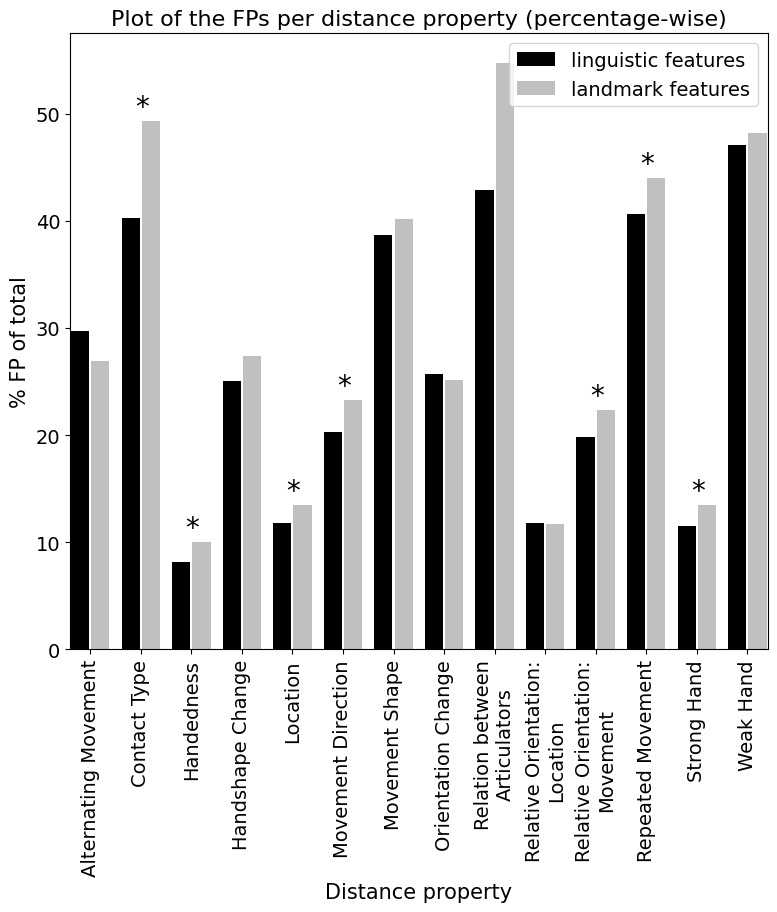

In [27]:
# Plot the bars of the percentage-wise FP counts in one plot for both models
# From: https://stackoverflow.com/questions/14270391/how-to-plot-multiple-bars-grouped
def bar_plot_multiple(ax, data, colors=None, total_width=0.8, single_width=1, legend=True, font_size = 12):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """
    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []
    heights_left_bar = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])
            height = bar[0].get_height()
            width = bar[0].get_width()
            loc = bar[0].get_x()
            
            if i % 2 == 0:
                heights_left_bar.append(height)

            # Add an asterisk where the diff between two percentages is significant
            if i % 2 == 1 and statistically_sign_ling[x]:
                text_height = max(heights_left_bar[x], height)
                plt.text(loc, text_height, '*', ha='center', va='bottom', fontsize = 20) 

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])
        
    # Draw legend if legend = True
    if legend:
        ax.legend(bars, data.keys(), fontsize = font_size, loc = 'upper right')
        
        
data = {'linguistic features': ling_fp_diff_counts, 
        'landmark features': lmrk_fp_diff_counts}

# Resize figure, choose fontsize 
fig, ax = plt.subplots(figsize=(9, 8))
font_size = 14

# Plot the bars and significances
bar_plot_multiple(ax, data, total_width=.8, single_width=0.9, colors = ['black', 'silver'], font_size = font_size )

# Wrap label text so it fits better in the plot
linguistic_labels = list(set(ling_fp_diff_properties))
labels_wrapped = wrap_text_in_list(sorted(linguistic_labels))

# Add text to the plot
plt.title('Plot of the FPs per distance property (percentage-wise)', fontsize = font_size + 2)
plt.xticks(range(len(labels_wrapped)), labels_wrapped, rotation = 90, fontsize = font_size)
plt.yticks(fontsize = font_size)
plt.ylabel('% FP of total', fontsize = font_size+1)
plt.xlabel('Distance property', fontsize = font_size+1)
plt.xlim(-0.4, 13.4)

# Store the plot as a .png
plt.savefig('FPs_distance_property.png', bbox_inches = 'tight')
plt.show()